## **QRT Data Challenge: Stock Return Prediction**

#### Auteur: Naïl Khelifa

### Packages

In [134]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import GradientBoostingClassifier
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA

### Chargement des données

In [50]:
x_train = pd.read_csv('x_train_Lafd4AH.csv')
y_train = pd.read_csv('y_train_JQU4vbI.csv')
x_test = pd.read_csv('x_test_c7ETL4q.csv')

In [44]:
x_train.head(5)

,ID,DATE,STOCK,INDUSTRY,INDUSTRY_GROUP,SECTOR,SUB_INDUSTRY,RET_1,VOLUME_1,RET_2,...,RET_16,VOLUME_16,RET_17,VOLUME_17,RET_18,VOLUME_18,RET_19,VOLUME_19,RET_20,VOLUME_20
0,0,0,2,18,5,3,44,-0.015748,0.147931,-0.015504,...,0.059459,0.630899,0.003254,-0.379412,0.008752,-0.110597,-0.012959,0.174521,-0.002155,-0.000937
1,1,0,3,43,15,6,104,0.003984,NaN,-0.090580,...,0.015413,NaN,0.003774,NaN,-0.018518,NaN,-0.028777,NaN,-0.034722,NaN
2,2,0,4,57,20,8,142,0.000440,-0.096282,-0.058896,...,0.008964,-0.010336,-0.017612,-0.354333,-0.006562,-0.519391,-0.012101,-0.356157,-0.006867,-0.308868
3,3,0,8,1,1,1,2,0.031298,-0.429540,0.007756,...,-0.031769,0.012105,0.033824,-0.290178,-0.001468,-0.663834,-0.013520,-0.562126,-0.036745,-0.631458
4,4,0,14,36,12,5,92,0.027273,-0.847155,-0.039302,...,-0.038461,-0.277083,-0.012659,0.139086,0.004237,-0.017547,0.004256,0.579510,-0.040817,0.802806


In [62]:
print(f"on a {x_train.shape[0]} observations de {x_test.shape[1]} features")
print(f"on a {len(x_train['STOCK'].unique())} actifs")

on a 418595 observations de 47 features
on a 5350 actifs


#### **Remarques sur les données de `x_train`**

On dispose donc de 47 features et de 418595 observations. Cependant, à l'observation des 5 premières lignes de x_train, on observe qu'il y a des valeurs manquantes. On souhaite corriger ces NaN. Une première chose à faire est donc de nettoyer `x_train`. On remarque que si l'on retire les lignes associées à ces valeurs manquantes, on perd trop d'information sur certains stocks, cest pourquoi on remplace les valeurs manquantes par 0.

In [64]:
x_train.fillna(0., inplace=True)

En observant `y_train`, on se rend compte qu'il s'agit un problème de classification binaire. À partir de là, une première approche de sélection de feature est d'étudier la répartition de chaque feature dans chaque classe. 

In [72]:
y_train['RET'] = y_train['RET'].replace({True: 1, False: 0})
merged_x_train = pd.merge(x_train, y_train[['ID', 'RET']], on='ID')
merged_x_train

,ID,DATE,STOCK,INDUSTRY,INDUSTRY_GROUP,SECTOR,SUB_INDUSTRY,RET_1,VOLUME_1,RET_2,...,VOLUME_16,RET_17,VOLUME_17,RET_18,VOLUME_18,RET_19,VOLUME_19,RET_20,VOLUME_20,RET
0,0,0,2,18,5,3,44,-0.015748,0.147931,-0.015504,...,0.630899,0.003254,-0.379412,0.008752,-0.110597,-0.012959,0.174521,-0.002155,-0.000937,1
1,1,0,3,43,15,6,104,0.003984,0.000000,-0.090580,...,0.000000,0.003774,0.000000,-0.018518,0.000000,-0.028777,0.000000,-0.034722,0.000000,1
2,2,0,4,57,20,8,142,0.000440,-0.096282,-0.058896,...,-0.010336,-0.017612,-0.354333,-0.006562,-0.519391,-0.012101,-0.356157,-0.006867,-0.308868,0
3,3,0,8,1,1,1,2,0.031298,-0.429540,0.007756,...,0.012105,0.033824,-0.290178,-0.001468,-0.663834,-0.013520,-0.562126,-0.036745,-0.631458,0
4,4,0,14,36,12,5,92,0.027273,-0.847155,-0.039302,...,-0.277083,-0.012659,0.139086,0.004237,-0.017547,0.004256,0.579510,-0.040817,0.802806,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
418590,418590,223,5703,32,10,4,77,0.021843,-0.217823,-0.021703,...,-0.161543,0.007785,-0.141487,0.008205,-0.268215,-0.058448,0.057577,0.031174,-0.163350,0
418591,418591,223,5705,35,12,5,91,-0.006920,-0.375251,0.000000,...,-0.955492,-0.016221,-0.171172,0.007819,1.540184,-0.015396,-0.502337,-0.011073,0.632885,0
418592,418592,223,5709,2,1,1,5,0.021869,-0.978856,-0.005929,...,-0.476550,0.029714,-0.385972,-0.069148,1.780169,-0.082927,1.581453,0.098607,6.956960,1
418593,418593,223,5710,33,10,4,83,0.012248,-0.627169,0.010925,...,-0.210079,0.023729,0.813948,0.026087,-0.868576,-0.051155,0.371052,0.041238,0.045695,1


On commence par transformer le dataset. On aimerait avoir une base de données avec en ligne le numéro du stock et avec en colonne les features. De sorte à ce que chaque élément du Datassette correspondent à une liste contenan toute les observations de ce feature pour le stock donné.

In [73]:
# Créer une liste de toutes les colonnes de features (RET_i et VOLUME_i)
ret_columns = [f'RET_{i}' for i in range(1, 21)]
volume_columns = [f'VOLUME_{i}' for i in range(1, 21)]

# Grouper par 'STOCK' et appliquer la transformation pour obtenir des tableaux numpy par feature
transformed_data = {}
for column in ret_columns + volume_columns + ['RET']:
    transformed_data[column] = merged_x_train.groupby('STOCK')[column].apply(lambda x: np.array(x))

# Convertir en DataFrame pour obtenir le format souhaité
transformed_x_train = pd.DataFrame(transformed_data)
transformed_x_train.head(3)

,RET_1,RET_2,RET_3,RET_4,RET_5,RET_6,RET_7,RET_8,RET_9,RET_10,...,VOLUME_12,VOLUME_13,VOLUME_14,VOLUME_15,VOLUME_16,VOLUME_17,VOLUME_18,VOLUME_19,VOLUME_20,RET
STOCK,,,,,,,,,,,,,,,,,,,,,
0,"[-0.0059669713617936, 0.0013480334825179, -0.0...","[0.0090308307725444, 0.0111001907845291, 0.003...","[0.0082959410164575, 0.0120226233112301, 0.011...","[0.0026378992025406, -0.0164769150555652, 0.0,...","[0.0127389308754382, 0.0056537102473497, 0.002...","[0.0397343401153809, -0.0221122047125944, 0.00...","[-0.0008532613707511, -0.0092543746755998, -0....","[0.0289919491779371, 0.0037911636723635, 0.008...","[-0.0028476123980203, 0.0072568578981995, 0.00...","[-0.0060941142695922, -0.002856254598056, 0.00...",...,"[-0.3923386495123397, -0.4495899611488715, -0....","[0.0353919262672781, -0.3724656577168361, -0.1...","[0.0412995896712173, -0.2261815985241434, -0.2...","[-0.3820672562396299, -0.2491427625121033, -0....","[-0.4933543586370698, -0.3135752471239016, -0....","[-0.5854972515334218, 0.0713381754702875, -0.4...","[-0.3513631830822069, -0.4052426590921026, -0....","[-0.3246745173072086, -0.4243361656776324, -0....","[-0.2917506195727448, -0.0505914141416463, -0....","[0, 0, 1, 1, 0, 1, 0, 0, 1, 0, 0, 1, 1, 1, 0, ..."
1,"[0.0139480421946516, 0.0019941044480866, -0.01...","[0.0110060493650638, 0.0025438038360814, -0.00...","[0.0008603721520819, -0.0068577013987881, 0.02...","[0.0230673945403454, -0.0087657903424789, 0.01...","[0.0049551900170163, -0.0021418120664983, 0.00...","[0.0196678342513889, 0.0035827545016209, -0.00...","[-0.0044907544727136, -0.007996974102978, -0.0...","[0.0138407153783997, 0.0024942299215666, -0.01...","[-0.0093810950166882, 0.0064549352778766, -0.0...","[-0.0076977478345955, -0.0143159597131535, 0.0...",...,"[0.0, -0.4410877458725768, 1.531594376956409, ...","[0.0, -0.8266127880604341, 0.1483056631790651,...","[0.0, -0.502413935729947, 0.4012110801698862, ...","[0.0, -0.3674982061231675, 0.0, 0.220457882028...","[0.0, -0.8667725277161855, 0.0, -0.02651041373...","[0.0, -1.2012673556063698, 0.0, 0.534877413061...","[0.0, -0.4069068881432085, 0.0, 0.254452264305...","[0.0, -0.5754493468709349, 0.0, -0.50689939484...","[0.0, -0.675792829292539, 0.0, -0.278586535763...","[0, 0, 1, 0, 0, 0, 0, 0, 1, 0, 1, 0, 1, 0, 1, ..."
2,"[-0.0157480376960778, -0.0186708006623838, 0.0...","[-0.0155038819782489, -0.0177996320386364, -0....","[0.0109715930586977, -0.0200848361746395, -0.0...","[-0.0146716272863426, 0.0096056640386852, -0.0...","[0.0164833234857386, -0.0136847404433528, -0.0...","[0.014331213043633, 0.0354227761735532, -0.047...","[-0.017214593114241, 0.0082413484179528, 0.022...","[-0.018432802777574, 0.0294122097088587, -0.03...","[0.1341459059233449, 0.0406123077801421, -0.03...","[0.1822866071798679, 0.0011786989173381, -0.02...",...,"[-0.8164356492560926, -0.9031327258350536, 0.3...","[-0.2446359693803419, 0.0383966279717538, -1.1...","[-2.042623524632501, -0.5204619377793476, -0.2...","[-0.3696051463408142, -0.4934501640684579, 0.9...","[0.6308990270609234, -0.214853856386497, 0.373...","[-0.3794117706532677, -0.8008054368430658, 1.0...","[-0.1105968799677701, 0.2820388228709516, 0.39...","[0.1745206392456959, -0.2414214293544292, -0.6...","[-0.0009372680030632, 4.528611542082178, -0.49...","[1, 0, 0, 0, 0, 1, 1, 0, 0, 1, 0, 0, 0, 1, 1, ..."


### **Étude des features quantitatifs** 

Dans un premier temps, on laisse de côté les features qualitatif (secteur, industrie...) et on se concentre sur les features purement qualitatifs. La première chose que l'on remarque est que les obervations sont inégales d'un stock à l'autre. Si on regarde le nombre d'observations pour la variable `RET_1`on voit par exemple que 

Text(0.5, 1.0, "Distribution des longueurs des éléments dans transformed_x_train['RET_1']")

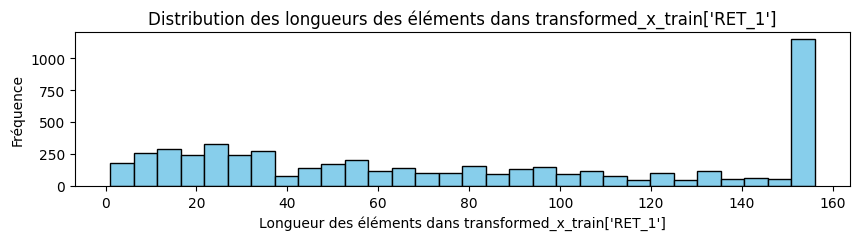

In [93]:
# Calcul des longueurs pour chaque élément dans transformed_x_train['RET_1']
lengths = [len(transformed_x_train['RET_1'][i]) for i in transformed_x_train.index]

# Création de la figure et des axes
fig, ax = plt.subplots(figsize=(10, 2))

# Tracer l'histogramme
ax.hist(lengths, bins=30, color='skyblue', edgecolor='black')
ax.set_xlabel('Longueur des éléments dans transformed_x_train[\'RET_1\']')
ax.set_ylabel('Fréquence')
ax.set_title('Distribution des longueurs des éléments dans transformed_x_train[\'RET_1\']')

Ce constat, qui peut être généralisé aux autres variables d'intérêts, nous incite à travailler sur des statistiques agrégées pour chaque actif. Ceci nous conduit au opérations d'agrégation suivante.

Text(0.5, 1.0, "Distribution des longueurs des éléments dans transformed_x_train['RET']")

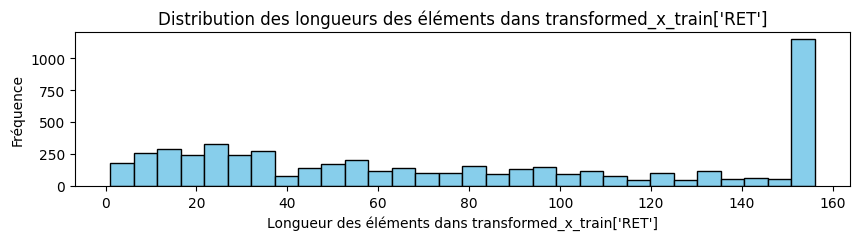

In [95]:
# Calcul des longueurs pour chaque élément dans transformed_x_train['RET_1']
lengths = [len(transformed_x_train['RET'][i]) for i in transformed_x_train.index]

# Création de la figure et des axes
fig, ax = plt.subplots(figsize=(10, 2))

# Tracer l'histogramme
ax.hist(lengths, bins=30, color='skyblue', edgecolor='black')
ax.set_xlabel('Longueur des éléments dans transformed_x_train[\'RET\']')
ax.set_ylabel('Fréquence')
ax.set_title('Distribution des longueurs des éléments dans transformed_x_train[\'RET\']')

## Exemple pour Id = 1 i.e. pour le premier stock

In [138]:
X_stock_1 = pd.DataFrame(transformed_x_train.iloc[1]).transpose()

# Initialiser un dataframe pour stocker les nouvelles lignes
transformed_X_stock_1 = pd.DataFrame(columns=X_stock_1.columns, index= np.arange(len(X_stock_1.iloc[0][1])))

for col in X_stock_1.columns:
    transformed_X_stock_1[col] = X_stock_1[col][1]

transformed_X_stock_1.head()

,RET_1,RET_2,RET_3,RET_4,RET_5,RET_6,RET_7,RET_8,RET_9,RET_10,...,VOLUME_12,VOLUME_13,VOLUME_14,VOLUME_15,VOLUME_16,VOLUME_17,VOLUME_18,VOLUME_19,VOLUME_20,RET
0,0.013948,0.011006,0.000860,0.023067,0.004955,0.019668,-0.004491,0.013841,-0.009381,-0.007698,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0
1,0.001994,0.002544,-0.006858,-0.008766,-0.002142,0.003583,-0.007997,0.002494,0.006455,-0.014316,...,-0.441088,-0.826613,-0.502414,-0.367498,-0.866773,-1.201267,-0.406907,-0.575449,-0.675793,0
2,-0.014093,-0.002237,0.023218,0.012080,0.006999,-0.003983,-0.038308,-0.013697,-0.005635,0.003929,...,1.531594,0.148306,0.401211,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1
3,-0.012332,-0.012541,-0.001271,0.007130,0.012963,0.000000,0.012184,-0.005035,0.019004,0.043633,...,0.046600,0.997804,1.381475,0.220458,-0.026510,0.534877,0.254452,-0.506899,-0.278587,0
4,-0.013222,0.003141,0.027987,0.005774,-0.007521,0.000538,0.003776,-0.010852,-0.006012,-0.008938,...,-0.070762,-0.261282,-0.592677,0.335297,0.565979,0.019689,0.356585,1.768691,-0.044637,0


Le dataset est tout de suite beaucoup plus maléable, et on a 103 observations avec les prédictions associées pour entraîner un modèle à prédire.

In [139]:
class_1_stock_1 = transformed_X_stock_1[transformed_X_stock_1['RET'] == 1]
class_0_stock_1 = transformed_X_stock_1[transformed_X_stock_1['RET'] == 0]

      Feature  Explained Variance - 0
0       RET_1                0.132769
1       RET_2                0.103296
2       RET_3                0.079239
3       RET_4                0.077368
4       RET_5                0.062572
5       RET_6                0.058375
6       RET_7                0.049836
7       RET_8                0.045974
8       RET_9                0.039261
9      RET_10                0.037666
10     RET_11                0.032804
11     RET_12                0.031111
12     RET_13                0.028529
13     RET_14                0.023763
14     RET_15                0.022737
15     RET_16                0.020083
16     RET_17                0.019527
17     RET_18                0.018194
18     RET_19                0.015881
19     RET_20                0.015420
20   VOLUME_1                0.012016
21   VOLUME_2                0.011144
22   VOLUME_3                0.009732
23   VOLUME_4                0.008609
24   VOLUME_5                0.007536
25   VOLUME_

KeyError: 'Explained Variance - 0'

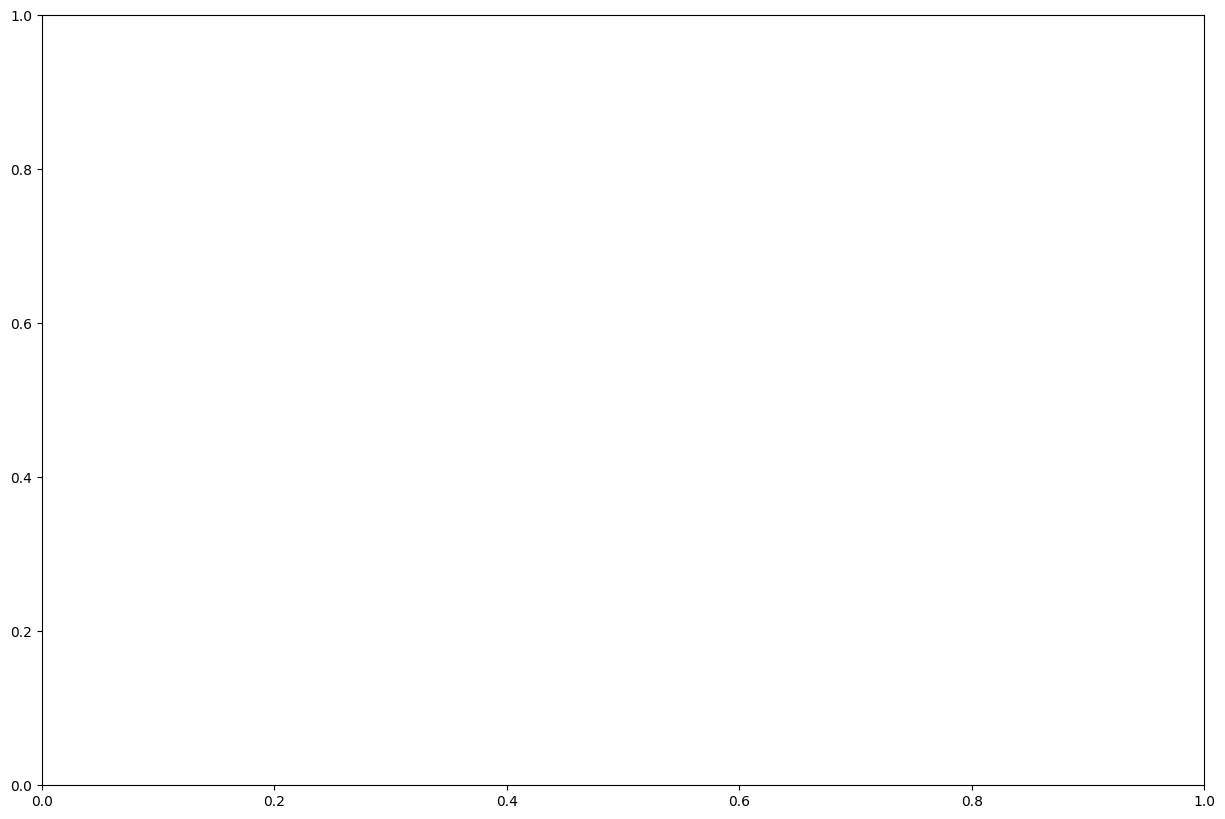

In [142]:
# Création d'une figure et d'un axe pour le graphique
fig, ax = plt.subplots(figsize=(15, 10))

# Liste des caractéristiques à analyser
features_list = X_stock_1.columns[:-1]


# Normalisation des données
scaler = StandardScaler()
class_1_stock_1_scaled = scaler.fit_transform(class_1_stock_1)
class_0_stock_1_scaled = scaler.fit_transform(class_0_stock_1)

# Exécution de la SVD
U_1, S_1, VT_1 = np.linalg.svd(class_1_stock_1_scaled, full_matrices=False)
U_0, S_0, VT_0  = np.linalg.svd(class_0_stock_1_scaled, full_matrices=False)

# Calcul de la variance expliquée
explained_variance_1 = (S_1**2) / np.sum(S_1**2)
explained_variance_0 = (S_0**2) / np.sum(S_0**2)

# Création d'un DataFrame pour associer les caractéristiques avec leur variance expliquée
explained_variance_df_menace = pd.DataFrame({
    'Feature': features_list,
    'Explained Variance - 1': explained_variance_1[:len(features_list)]
})

explained_variance_df_non_menace = pd.DataFrame({
    'Feature': features_list,
    'Explained Variance - 0': explained_variance_0[:len(features_list)]
})

# Tri des DataFrames par variance expliquée
explained_variance_df_non_menace.sort_values(by='Explained Variance - 0', ascending=False, inplace=True)
explained_variance_df_menace.sort_values(by='Explained Variance - 1', ascending=False, inplace=True)

# Affichage des variances expliquées triées
print(explained_variance_df_non_menace)
print(explained_variance_df_menace)

# Position des barres pour chaque feature
x = np.arange(len(features_list))
width = 0.35  # Largeur des barres pour les mettre côte à côte

# Barres pour la menace
ax.bar(x - width/2, explained_variance_df_menace['Explained Variance - 0'], 
       width, color='orange', alpha=0.7, label='0')

# Barres pour la non-menace
ax.bar(x + width/2, explained_variance_df_non_menace['Explained Variance - '], 
       width, color='purple', alpha=0.7, label='Non-Menace')

# Titre et labels du graphique
ax.set_title('Variance Expliquée par Caractéristique Selon la Population', fontsize=16)
ax.set_xlabel('Caractéristiques', fontsize=14)
ax.set_ylabel('Taux de Variance Expliquée', fontsize=14)
ax.set_xticks(x)
ax.set_xticklabels(features_list, rotation=45)  # Rotation des étiquettes de l'axe des x pour faciliter la lecture
ax.grid(axis='y')  # Affichage de la grille sur l'axe des y
ax.legend()  # Affichage de la légende

plt.show()